In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tensorflow as tf
import imblearn
from sklearn.model_selection import train_test_split
import collections

In [2]:
date='16Mar2021'
dir_name='/preprocessing/200PU_2806'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name

In [3]:
%%time
columns=['genpart_exeta',
         'genpart_pt',
 'cl3d_pt',
 'cl3d_eta',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'layer',
 'sample',
  'matches',
         
        ]
df= pd.read_csv(data_dir+'/cl3d.csv', usecols=columns, low_memory=True)
print('done')

done
CPU times: user 15.5 s, sys: 3.06 s, total: 18.5 s
Wall time: 18.6 s


<string>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
len(df[df['sample']=='PU'])

29757

In [5]:
for samp in ['elec', 'pion', 'PU']:
    print(samp,len(df[df['sample']==samp]))

elec 279928
pion 9545
PU 29757


In [6]:
df['genpart_exeta'][df['sample']=='PU']=0
df['genpart_pt'][df['sample']=='PU']=0
df['matches'][df['sample']=='PU']=0

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel pac

# Config

In [7]:
genptcut=20
cl3dptcut=5
PU_cut = 20
etamin=1.6
etamax=2.9
bkg='pions' # 'pions' or 'PU'
standardize = "_unstandardized"
feature_set=16 # 1: baseline 4: minimal, 10-13 + new vars (12 -> PU 13-> pions)
opti=False
res_dir=workdir+'/res/res_pt{}_vs{}_featset{}{}'.format(genptcut, bkg, feature_set, standardize)
os.makedirs(res_dir, exist_ok=True)

In [8]:
%%time
#cut
algo_cut={}

def tolist(x):
    x.test=x.layer[1:-1].split(',')
    return x.test
print(len(df))

#cut on pt gen level for electrons and pions
sel=((df['genpart_pt']>genptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]

#cut on cl3d_pt for elec and pions
sel=((df['cl3d_pt'] > cl3dptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]
print('elec and pions pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))

#cut on cl3d_pt for PU
sel=((df_cut['cl3d_pt'] > PU_cut) & (df_cut['sample']=='PU')) | (df_cut['sample']!='PU')
df_cut=df_cut[sel]
print('PU pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#cut on hgcal eta acceptance
sel=((np.abs(df_cut['genpart_exeta'])>etamin) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df_cut[sel]
print('min eta cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
sel=((np.abs(df_cut['genpart_exeta'])<etamax) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df_cut[sel]
print('max eta cut : ',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#drop incomplete events
df_cut.dropna(inplace=True)
print('drpna : ', len(df_cut))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#cut on cl3deta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])
sel=(df_cut['abseta']>etamin) & (df_cut['abseta']<etamax)
df_cut=df_cut[sel]
print('cl3d eta cut:', len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#layer_pt preproc
df_cut['layer_pt']=df_cut.apply(tolist, axis=1)
df_cut.drop('layer', axis=1, inplace=True)
print("done")
def layering (x):
    return float(x.layer_pt[n])

##besoin de créer une variable par layer?
algo_layer={}
n_layers=len(df_cut['layer_pt'].iloc[0])
#print(n_layers)
layer_columns=[]

for n in range(n_layers):
    print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
    df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
    layer_columns.append('layer_{}'.format(n))
print("done layering")



319230
elec and pions pt cut : 314710 275772
PU:  29757
PU pt cut : 314710 275772
PU:  29757


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


min eta cut : 294435 256235
PU:  29757


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


max eta cut :  262072 225066
PU:  29757
drpna :  262072
PU:  29757
cl3d eta cut: 261150 224441
PU:  29489
done
done layering36
CPU times: user 3min 20s, sys: 17.8 s, total: 3min 38s
Wall time: 3min 39s


In [9]:
for samp in ['elec', 'pion', 'PU']:
    print(samp,len(df_cut[df_cut['sample']==samp]))

elec 224441
pion 7220
PU 29489


In [10]:
# build new vars

#abseta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])

#variance
df_cut['varee']=df_cut['cl3d_seetot']**2
df_cut['varpp']=df_cut['cl3d_spptot']**2
df_cut['varzz']=df_cut['cl3d_szz']**2
df_cut['varrr']=df_cut['cl3d_srrtot']**2

#EoT: pt(Ecal)/pt(Tot)
nLayerEcal= 14
sumE=0

sumT=0
for i in range(n_layers):
    #print('Totlayer_{}'.format(i))
    sumT+=df_cut['layer_{}'.format(i)]
    
    
for i in range(1,nLayerEcal+1):
    #print('Ecal layer_{}'.format(i))
    sumE+=df_cut['layer_{}'.format(i)]
df_cut['EoT']=sumE/sumT

#fraction of pt in first x  layers and last x layers
maxfirst = 5
maxlast=10

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        Sum+=df_cut['layer_{}'.format(i)]
    df_cut['first_{}'.format(n)]= Sum/sumT
    
for n in range(1,maxlast):
    Sum=0
    #print(n, ' layers')
    for i in range(n_layers - n, n_layers):
        #print(n,i)
        Sum+=df_cut['layer_{}'.format(i)]
    #print('last_{}'.format(n), sum/sumT)
    df_cut['last_{}'.format(n)]= Sum/sumT
    
    

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        #print('layer_{}'.format(nLayerEcal+i))
        Sum+=df_cut['layer_{}'.format(nLayerEcal+i)]
    df_cut['firstHcal_{}'.format(n)]= Sum/sumT
    
    
# Emaxx : pt in x layers around Elec max layer (5)
maxpos=5

#print('emax_1')
Sum=0
Sum+=df_cut['layer_{}'.format(maxpos)]
df_cut['Emax_1']=Sum/sumT
 
#print('emax_2L')
Sum=0
for i in range(maxpos-1, maxpos+1):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2L']=Sum/sumT
    
#print('emax_2R')
Sum=0
for i in range(maxpos, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2R']=Sum/sumT
    
#print('emax_3')
Sum=0
for i in range(maxpos-1, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_3']=Sum/sumT
#print('emax_4G')
Sum=0
for i in range(maxpos-2, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4L']=Sum/sumT
#print('emax_4R')
Sum=0
for i in range(maxpos-1, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4R']=Sum/sumT
#print('emax_5')
Sum=0
for i in range(maxpos-2, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_5']=Sum/sumT
    
    
    

In [11]:
%%time
#do bitmaps with group
def ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def hbm(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['ebm0']=df_cut.apply(ebm0, axis=1)
df_cut['ebm1']=df_cut.apply(ebm1, axis=1)
df_cut['hbm']=df_cut.apply(hbm, axis=1)

CPU times: user 3min 13s, sys: 6.81 s, total: 3min 20s
Wall time: 3min 15s


In [12]:
# try in last lay -> first

In [13]:
#do bitmaps with group
def reverse_ebm0(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_ebm1(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_hbm(x):
    ebm=[]
    thr=0
    for i in range(n_layers-1,nLayerEcal-1, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['reverse_ebm0']=df_cut.apply(reverse_ebm0, axis=1)
df_cut['reverse_ebm1']=df_cut.apply(reverse_ebm1, axis=1)
df_cut['reverse_hbm']=df_cut.apply(reverse_hbm, axis=1)
print('done')

done


In [14]:
# quantization

def quantize(feat, nbits, method): #feat is the feature to quantize, nbist the number of bits, method: 'uniform' or 'percentile'
    nbins= 2**nbits
    fmin=feat.min()
    fmax=feat.max()
    if method == 'uniform':
        bins=np.linspace(fmin, fmax, nbins+1)
    elif method == 'percentile':
        bins=[np.percentile(feat, n) for n in np.linspace(0,100,nbins+1)]
    else :
        print('Error: Invalid method')
        return
    
    
    
    return np.digitize(feat, bins)

In [15]:
print(df_cut.columns.tolist())

['genpart_exeta', 'genpart_pt', 'cl3d_pt', 'cl3d_eta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'matches', 'sample', 'abseta', 'layer_pt', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28', 'layer_29', 'layer_30', 'layer_31', 'layer_32', 'layer_33', 'layer_34', 'layer_35', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2', 'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4', 'last_5', 'last_6', 'last_

In [16]:
#plot features distrib
plot= False
if plot:
    var_list= ['cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
           'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_spptot',
           'cl3d_szz', 'cl3d_srrtot',
           'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
           'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 
           'abseta', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2',
            'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4',
            'last_5', 'last_6', 'last_7', 'last_8', 'last_9', 'firstHcal_1', 'firstHcal_2',
            'firstHcal_3', 'firstHcal_4', 'firstHcal_5', 'Emax_1', 'Emax_2L', 'Emax_2R', 'Emax_3',
            'Emax_4L', 'Emax_4R', 'Emax_5', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']

    nbins=100
    binmin=[1, 1, 1, 1, 0, 0, 0.0, 0.0, 0., -1.0, 328.15726, 0., 1.5, 4.004325, 0.67, 0.9, 1.6, 0, 0, 0.0, 0.0,
     0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0,0,0,0,0,0,0,0,0,0,0,0]
    binmax=[50.0, 36.0, 34.0, 50.0, 0.09, 0.075, 90, 0.01, 1, 5, 500, 36, 36, 36, 80, 200, 2.9, 0.007,
         0.005, 800, 0.0001, 1.0, 0.01, 0.03, 0.15, 0.5, 0.5,0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 
            0.3, 0.3,0.4, 0.6, 0.6,0.25,0.62,0.9,18000,9000,65536,18000,9000,65536]
    
    os.makedirs(workdir + '/distrib', exist_ok=True)
    for i,feat in enumerate(var_list):
        if i in [0,1,2,3]:
            nbins=36
        else: nbins= 100
        #print(feat, binmin[i], binmax[i])
        bins=np.linspace(binmin[i],binmax[i],nbins)
        plt.figure(figsize=(12,7))
        plt.hist(df_cut[feat][df_cut['sample']=='elec'], bins=bins, label='elec', density=True, histtype='step')
        plt.hist(df_cut[feat][df_cut['sample']=='pion'],bins=bins, label='pions', density=True, histtype='step')
        plt.hist(df_cut[feat][df_cut['sample']=='PU'],bins=bins, label='PU', density=True, histtype='step')
        plt.title("{} distribution ".format(feat))
        #plt.yscale('log')
        #plt.xlim(0,36)
        plt.legend()

        plt.savefig(workdir+'/distrib/{}.png'.format(feat))

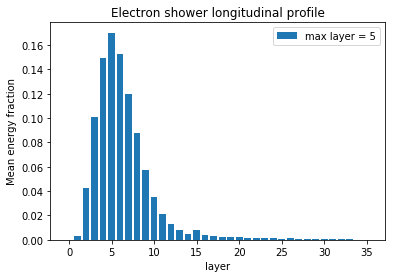

In [17]:
# plot longitudinal profile: mean fraction of elec pt / layer
frac={}
for n in range(n_layers):
    frac[n]=df_cut[df_cut['sample']=="elec"]['layer_{}'.format(n)]/df_cut[df_cut['sample']=="elec"]['cl3d_pt']
meanfrac=[frac[n].mean() for n in range(n_layers)]
plt.bar(range(n_layers),meanfrac, label= 'max layer = 5')
plt.xlabel('layer')
plt.ylabel('Mean energy fraction')
plt.title('Electron shower longitudinal profile')
plt.legend()

In [18]:
feature_set=2

In [19]:
if feature_set == 1:
    name = 'minimal w/ var'
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                'cl3d_meanz','cl3d_showerlength','cl3d_coreshowerlength'] #hoe/maxlayer
if feature_set == 2:
    name = 'baseline w/ var'
    features =  ['cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer','cl3d_maxlayer','varee', 'varzz',
    'varpp', 'varrr',  'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
    'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'abseta']

if feature_set == 3:
    name = 'minimal w/ var & EoT'
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'EoT', 'cl3d_showerlength','cl3d_coreshowerlength'] #hoe/maxlayer

if feature_set == 4:
    name = 'minimal w/ var & EoT & layervar & bitmap '
    features = ['cl3d_meanz','cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer',
                'abseta', 'varee', 'varpp', 'varzz', 'varrr',
                  'EoT', 'first_1', 'first_2',
                'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4',
                'last_5', 'last_6', 'last_7', 'last_8', 'last_9', 'firstHcal_1', 'firstHcal_2',
                'firstHcal_3', 'firstHcal_4', 'firstHcal_5', 'Emax_1', 'Emax_2L', 'Emax_2R', 'Emax_3',
                'Emax_4L', 'Emax_4R', 'Emax_5', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']


if feature_set == 5:
    name = 'minimal w/ var & best pions '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',
                'Emax_5', 'ebm1', 'first_5', 'Emax_4R', 'firstHcal_1', 'hbm']
    
        
if feature_set == 6:
    name = 'minimal w/ var & best PU '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT',
                 'ebm1', 'Emax_5', 'Emax_2R', 'first_4', 'Emax_4R', 'Emax_1']

In [20]:
#chose signal and background
#weight calc

df_cut['signal']= 5
df_cut['weight']=0
df_cut['signal'][df_cut['sample']=='elec']= 1
df_cut['signal'][df_cut['sample']!='elec'] = 0

if bkg == 'pions':
    print('pions')

    data=df_cut[df_cut['sample']!='PU']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='pion'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))

elif bkg == 'PU':
    print('PU')
    data=df_cut[df_cut['sample']!='pion']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='PU'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event

    data['weight'][data['signal']==0]=wb
    data['weight'][data['signal']==1]=ws
print('signal weight = {}, bkg weight ={}'.format(ws, wb))

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


pions


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be s

signal weight = 1.0321688105114484, bkg weight =32.08601108033241


In [21]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

#blancing illustration: hoe vs meanz
test= X_train_untouched[['cl3d_hoe', 'cl3d_meanz']]
plt.figure()
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==0],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==0], label='pions', s=2 )
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==1],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

oversample=imblearn.over_sampling.ADASYN()
X_smote2d, y_smote2d=oversample.fit_resample(X=X_train_untouched , y=y_train_untouched['signal'])

plt.figure()
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==0],X_smote2d['cl3d_meanz'][y_smote2d==0], label='pions', s=2 )
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==1],X_smote2d['cl3d_meanz'][y_smote2d==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

#blancing illustration: hoe vs meanz
test= X_train_untouched[['cl3d_hoe', 'cl3d_meanz']]
plt.figure()
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==0],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==0], label='pions', s=2 )
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==1],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

oversample=imblearn.over_sampling.SMOTE()
X_smote2d, y_smote2d=oversample.fit_resample(X=X_train_untouched , y=y_train_untouched['signal'])

plt.figure()
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==0],X_smote2d['cl3d_meanz'][y_smote2d==0], label='pions', s=2 )
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==1],X_smote2d['cl3d_meanz'][y_smote2d==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

In [22]:
balancing='comb' #'SMOTE', 'weights', 'ada', 'under', 'comb'

In [23]:
Counter= collections.Counter

In [24]:
#normalize features
from sklearn import preprocessing
import pickle
scaler = preprocessing.StandardScaler()
x=data[features]

for key in features:
        print(key, x[key].mean(), x[key].std())
if standardize==  "_Standardized":
    X=scaler.fit_transform(x)
else :X = x
pickle.dump(scaler, open(f"{res_dir}/scaler_model.pkl", "wb"))

X_train, X_test, y_train, y_test = train_test_split(X, data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']], test_size=0.2,random_state=42)

# implement different balancing
print('initial',Counter(y_train['signal']))
# SMOTE
oversample=imblearn.over_sampling.SMOTE()
X_smote, y_smote=oversample.fit_resample(X=X_train , y=y_train['signal'])
print('smote',Counter(y_smote))
#ADASYN
oversample=imblearn.over_sampling.ADASYN()
X_ada, y_ada=oversample.fit_resample(X=X_train , y=y_train['signal'])
print('ADASYN',Counter(y_ada))
#Under
undersample= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under=undersample.fit_resample(X=X_train, y=y_train['signal'])
print('under',Counter(y_under))
#over+under
over=imblearn.over_sampling.SMOTE(sampling_strategy=0.2)
under= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
X_comb, y_comb=over.fit_resample(X_train,y_train['signal'])
print('combined',Counter(y_comb))
X_comb, y_comb=under.fit_resample(X_comb, y_comb)
print('combined',Counter(y_comb))

cl3d_showerlength 33.0113527956799 6.695610615281548
cl3d_coreshowerlength 14.120827415922404 2.3132697540546894
cl3d_firstlayer 1.037956324111525 0.47269047601783054
cl3d_maxlayer 9.707853285619937 4.093935436452449
varee 0.00042903765717192826 0.000404844473758761
varzz 106.00507035182007 207.1655906541605
varpp 0.0004753130138158647 0.0003891932328880336
varrr 1.4399448887792941e-05 3.915760994702288e-06
cl3d_emaxe 0.1760215101530426 0.026659143066830798
cl3d_hoe 0.553392184802484 10.146175113467178
cl3d_meanz 338.21820572944955 9.138638092356512
cl3d_layer10 2.828237239070236 1.7300076307809733
cl3d_layer50 5.376163035616267 2.138684404463199
cl3d_layer90 9.027665140102998 2.9995175173205344
cl3d_ntc67 14.382615265707045 4.765286803566825
cl3d_ntc90 50.87586479816499 13.30405884639647
abseta 2.237747437774593 0.3718524963334378
initial Counter({1: 179505, 0: 5823})
smote Counter({1: 179505, 0: 179505})
ADASYN Counter({0: 179532, 1: 179505})
under Counter({1: 11646, 0: 5823})
combin

#plot pions distrib with smote and ada
plt.figure()
#plt.hist(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==1], bins=np.linspace(0,5,100), label='Electrons', density=True, linewidth=2)
plt.hist(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==0], bins=np.linspace(0,5,100), label='Initial pions', density=True, histtype='step', linewidth=2)
plt.hist(X_smote['cl3d_hoe'][y_smote==0], bins=np.linspace(0,5,100), label='SMOTE', histtype='step', density=True, linewidth=2)
plt.hist(X_ada['cl3d_hoe'][y_ada==0], bins=np.linspace(0,5,100), label='ADASYN', histtype='step', density=True, linewidth=2)
plt.legend()
plt.xlabel('hoe')

plt.figure()
#plt.hist(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==1], bins=np.linspace(0,5,100), label='Electrons', density=True, linewidth=2)
plt.hist(X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==0], bins=np.linspace(325,450,100), label='Initial pions', density=True, histtype='step', linewidth=2)
plt.hist(X_smote['cl3d_meanz'][y_smote==0], bins=np.linspace(325,450,100), label='SMOTE', histtype='step', density=True, linewidth=2)
plt.hist(X_ada['cl3d_meanz'][y_ada==0], bins=np.linspace(325,450,100), label='ADASYN', histtype='step', density=True, linewidth=2)
plt.legend()
plt.xlabel('meanz')

In [25]:
train_untouched=xgb.DMatrix(data=X_train,label=y_train['signal'],feature_names=features)
y_train_untouched=y_train
X_train_untouched=X_train
if balancing == 'SMOTE':
    X_train=X_smote
    y_train=pd.DataFrame(y_smote)
    y_train['weight']=1
    
    
elif balancing == 'ada':
    X_train=X_ada
    y_train=pd.DataFrame(y_ada)
    y_train['weight']=1
    
elif balancing == 'under':
    X_train=X_under
    y_train=pd.DataFrame(y_under)
    y_train['weight']=1
    
elif balancing == 'comb':
    X_train=X_comb
    y_train=pd.DataFrame(y_comb)
    y_train['weight']=1


train= xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features, weight=y_train['weight'])
test= xgb.DMatrix(data=X_test,label=y_test['signal'],feature_names=features)


In [26]:
res_dir=workdir+'/res/res_pt{}_vs{}_featset{}/{}'.format(genptcut, bkg, feature_set, balancing)
os.makedirs(res_dir, exist_ok=True)

In [27]:
%%time
opti=False
if opti ==True:
    param = {
        # Parameters that we are going to tune.
        'nthread':16,
        'max_depth':4,
        'eta':0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # Other parameters
        'objective':'binary:logistic',
        'eval_metric': 'auc', 
    }


    #use gpu if available
    gpu=tf.test.is_gpu_available(
        cuda_only=False, min_cuda_compute_capability=None
    )
    if gpu==True:
        print('gpu available')
        param['tree_method']='gpu_hist'
    else: print('no gpu found')



    num_boost_round=200
    
    #watchlist=
    progress={}

    metrics={'logloss','auc'} #last one used for es




    # grid search:
    gridsearch_params = [
        (max_depth, eta, l1, l2, es_rounds)
        for max_depth in [2,3,4]
        for eta in [0.001,0.005,0.01,0.05,0.1]
        for l1 in [0.01, 0.1,1,10] #alpha, def= 0
        for l2 in [0.01, 0.1,1,10] #lambda, def=1
        for es_rounds in [3,5]
    ]
    
    tot_iter=len(gridsearch_params)
    n_iter=0
    max_score = 0
    best_params = None
    for max_depth, eta, l1, l2,es_rounds in gridsearch_params:
        n_iter+=1
        print("CV {}/{} with max_depth={}, eta={}, l1={}, l2={}, es={}".format(n_iter, tot_iter,
                                 max_depth, eta, l1, l2, es_rounds))
        # Update our parameters
        param['max_depth'] = max_depth
        param['eta'] = eta
        param['alpha']= l1
        param['lambda']=l2
        # Run CV
        cv_results = xgb.cv(
            param,
            train,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics={'auc'},
            early_stopping_rounds=es_rounds
        )
        # Update best MAE
        alpha=10 #heavy empohasis on keeping train/test close
        mean_score = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
        boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
        print("\tScore {} in {} rounds".format(mean_score, boost_rounds))
        if mean_score > max_score:
            max_score = mean_score
            best_params = (max_depth,eta, l1, l2, es_rounds)
    print("Best params: {},  Score: {}".format(best_params, max_score))

CPU times: user 43 µs, sys: 0 ns, total: 43 µs
Wall time: 23.4 µs


minimal best : (2,0.1,0.01,10,3)
full best (2,0.01,10,10,5)

W0723 11:24:11.122281 140163906643776 deprecation.py:323] From <ipython-input-28-072b196206bf>:17: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


best score:0.9989214000000003 reached in 199 rounds


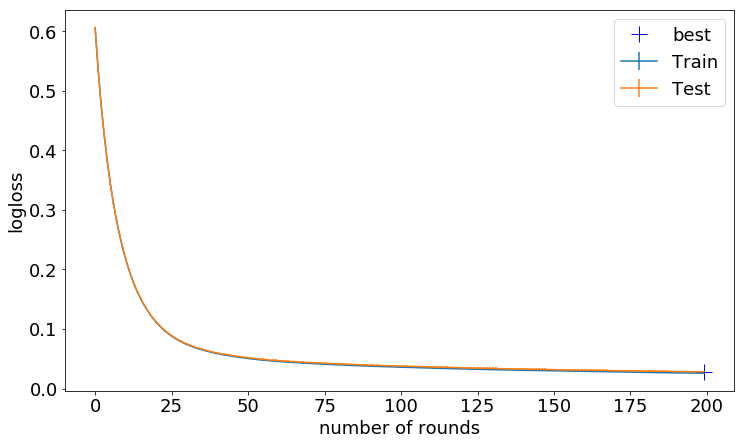

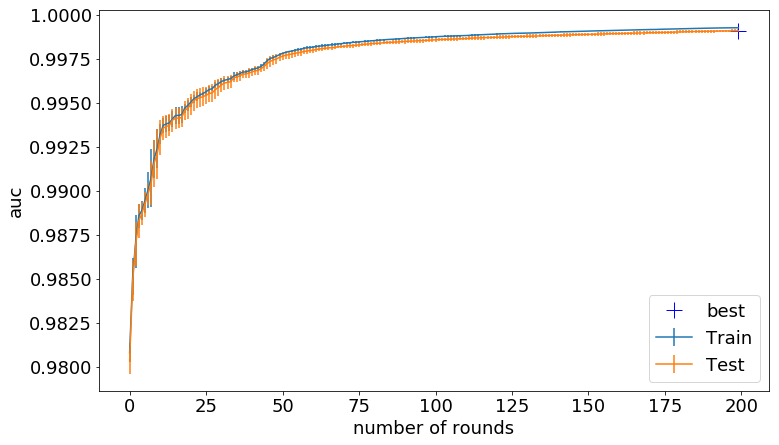

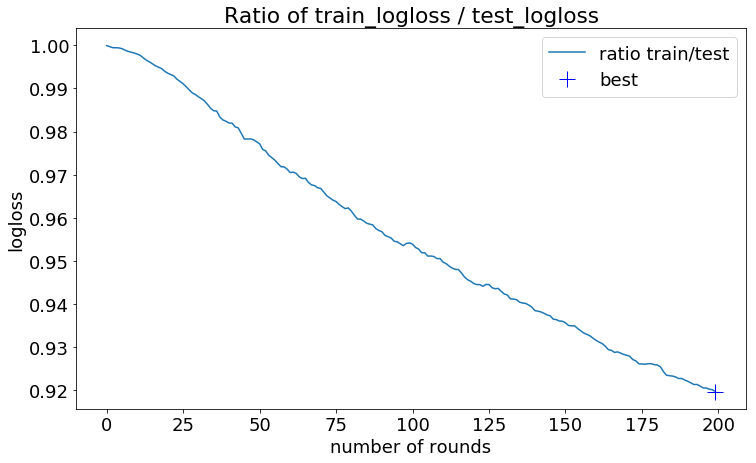

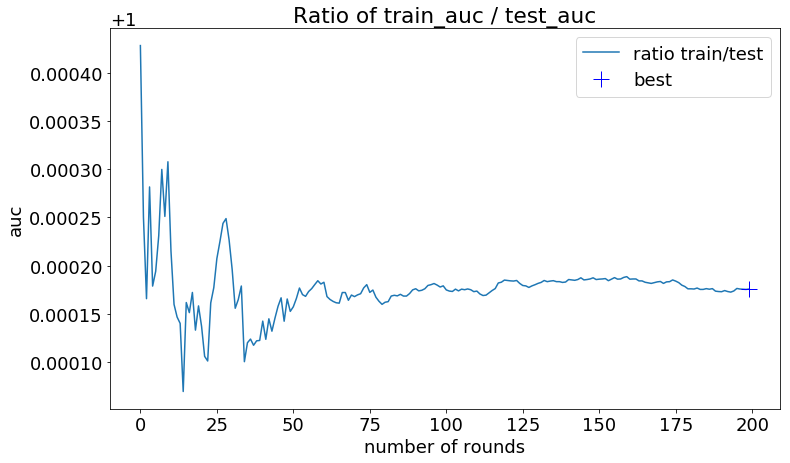

In [28]:
param = {
    'nthread' : 8,
    # Parameters that we are going to tune.
    'max_depth':2,
    'eta':0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric': 'auc', 
    'alpha':0.01,
    'lambda':10,
}

#use gpu if available
gpu=tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
if gpu==True:
    param['tree_method']='gpu_hist'

num_boost_round=200
es_rounds=3

metrics={'logloss','auc'} #last one used for es
# set up cross validation:
print('beginning cv')
cv_results = xgb.cv(
    param,
    train,
    num_boost_round=num_boost_round,
    seed=40,
    nfold=5,
    metrics=metrics,
    #feval=SoverB,
    early_stopping_rounds=es_rounds,
    shuffle=True,
    verbose_eval=2
)

## we define best score as the best test_auc penalized by the gap between train and test auc
alpha=1 #(penalization)

best_score=(cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
print('best score:{} reached in {} rounds'.format(best_score, boost_rounds))


for metric in metrics:
    
    plt.figure(figsize=(12,7))
    x_axis=range(0,len(cv_results))
    plt.errorbar(x=x_axis,y=cv_results['train-{}-mean'.format(metric)],xerr=None, yerr=cv_results['train-{}-std'.format(metric)], label='Train')
    plt.errorbar(x=x_axis,y=cv_results['test-{}-mean'.format(metric)],xerr=None, yerr=cv_results['test-{}-std'.format(metric)], label='Test')
    plt.plot(boost_rounds, cv_results['test-{}-mean'.format(metric)][boost_rounds], 'b+', label='best', markersize=16)
    #plt.vlines(x=boost_rounds, ymin=0, ymax=cv_results['train-{}-mean'.format(metric)].max(), label='best score')
    plt.ylabel(metric)
    #plt.ylim(0.4,0.9)
    plt.xlabel('number of rounds')
    plt.legend()
    plt.savefig(res_dir+'/{}.png'.format(metric))

#plot ratio train/test
for metric in metrics:
    
    plt.figure(figsize=(12,7))
    x_axis=range(0,len(cv_results))
    ratio = (cv_results['train-{}-mean'.format(metric)]/cv_results['test-{}-mean'.format(metric)])
    plt.plot(ratio, label='ratio train/test')
    #plt.errorbar(x=x_axis,y=cv_results['test-{}-mean'.format(metric)],xerr=None, yerr=cv_results['test-{}-std'.format(metric)], label='Test')
    plt.plot(boost_rounds, ratio[boost_rounds], 'b+', label='best', markersize=16)
    #plt.vlines(x=boost_rounds, ymin=0, ymax=cv_results['train-{}-mean'.format(metric)].max(), label='best score')
    plt.ylabel(metric)
    #plt.ylim(0.8,1.2)
    plt.xlabel('number of rounds')
    plt.title('Ratio of train_{} / test_{}'.format(metric, metric))
    plt.legend()
    plt.savefig(res_dir+'/{}_ratio.png'.format(metric))

In [29]:
res_dir

'/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset2/comb'

In [30]:
bkg

'pions'

Training on 107703 events, signal : 71802, bkg: 35901
Testing on 46333 events, signal : 44936, bkg: 1397
[0]	Train-auc:0.98034	Test-auc:0.97892
[10]	Train-auc:0.99392	Test-auc:0.99275
[20]	Train-auc:0.99516	Test-auc:0.99304
[30]	Train-auc:0.99624	Test-auc:0.99514
[40]	Train-auc:0.99699	Test-auc:0.99562
[50]	Train-auc:0.99762	Test-auc:0.99636
[60]	Train-auc:0.99820	Test-auc:0.99668
[70]	Train-auc:0.99841	Test-auc:0.99670
[80]	Train-auc:0.99854	Test-auc:0.99699
[90]	Train-auc:0.99867	Test-auc:0.99690
[98]	Train-auc:0.99872	Test-auc:0.99693
model saved
KS test passed for sig: cannot distinguish the 2 distributions (pvalue =0.11528912470602526)
KS test passed for bkg: cannot distinguish the 2 distributions (pvalue =1.0)
AUC Score (Test): 99.692614%
AUC Score (Test): 99.872085%
AUC Score (Test): 99.756221%


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


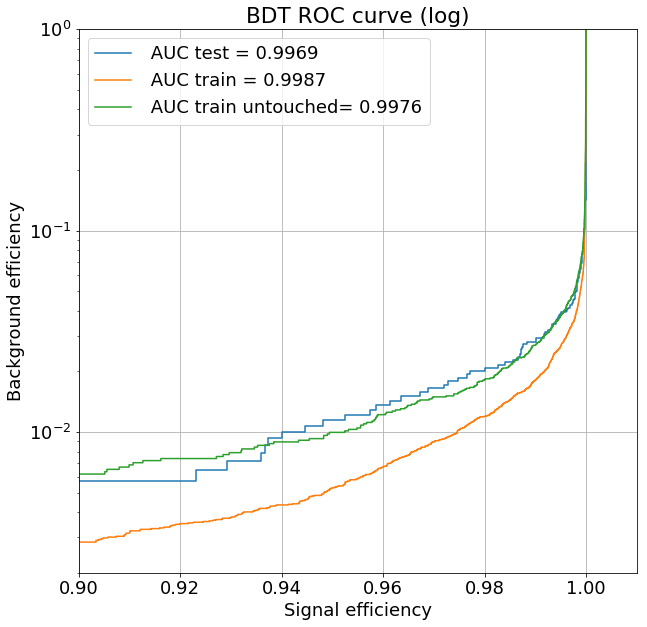

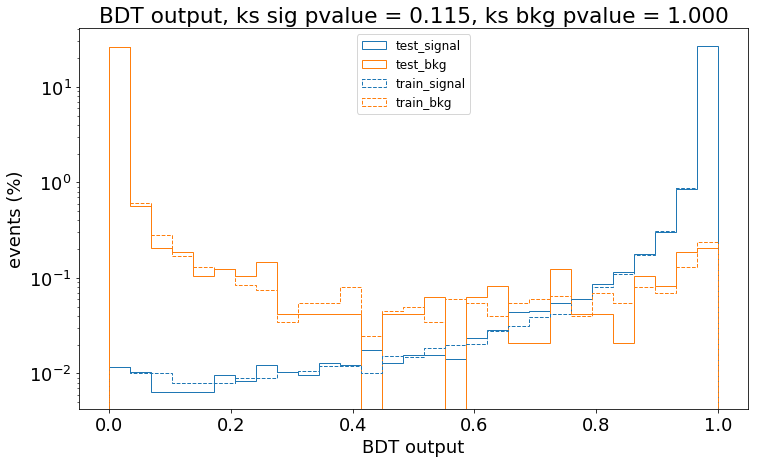

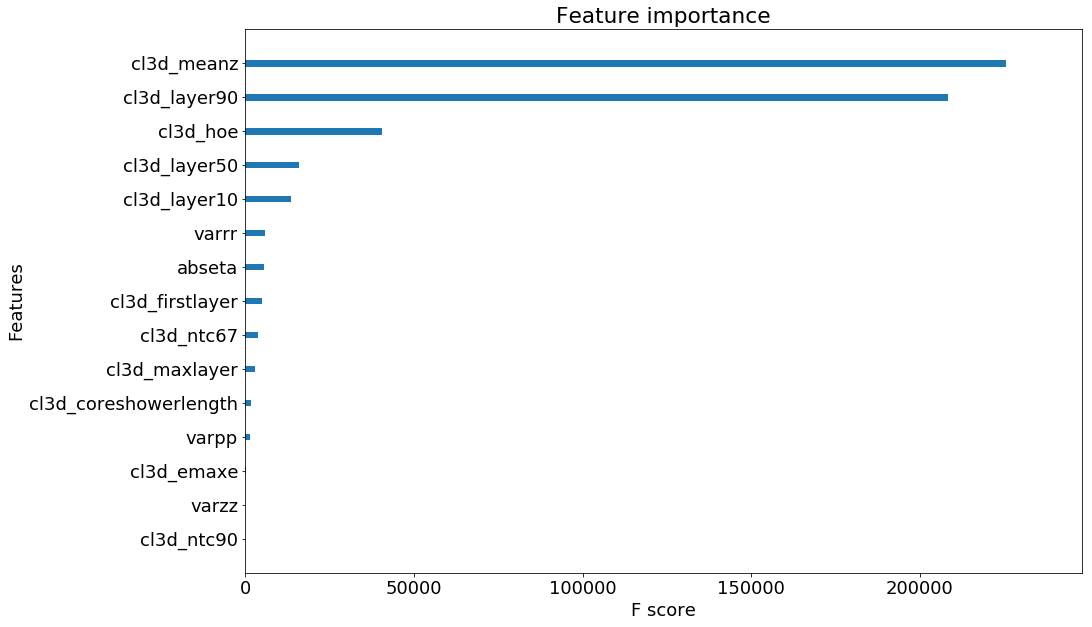

In [31]:
#Now train and fit best parameters BDT



print('Training on {} events, signal : {}, bkg: {}'.format(len(y_train),len(y_train[y_train['signal']==1]),len(y_train[y_train['signal']==0])))
print('Testing on {} events, signal : {}, bkg: {}'.format(len(y_test),len(y_test[y_test['signal']==1]),len(y_test[y_test['signal']==0])))
eval_result = {}
BDT = xgb.train(
    param,
    train,
    num_boost_round=int(boost_rounds/2),
    #feval = SoverB,
    evals=[(train, 'Train'),(test, "Test")],
    evals_result = eval_result,
    verbose_eval=10,
)
BDT.save_model(res_dir+'/model.model')
print('model saved')
predictions_BDT_test=BDT.predict(test)
predictions_BDT_train=BDT.predict(train)
predictions_BDT_train_untouched=BDT.predict(train_untouched)
y_test['BDT']=predictions_BDT_test
#y_test['BDT_layer']=pred_PU_layer

#kolmogorov test 
from scipy import stats
ks_test_sig=stats.ks_2samp(predictions_BDT_test[y_test['signal']==1],predictions_BDT_train_untouched[y_train_untouched['signal']==1])
ks_test_bkg=stats.ks_2samp(predictions_BDT_test[y_test['signal']==0],predictions_BDT_train_untouched[y_train_untouched['signal']==0])
if ((ks_test_sig[1]>=0.05) & (ks_test_bkg[1]>=0.05)):  #pass test if pvalue > 5%
    print('KS test passed for sig: cannot distinguish the 2 distributions (pvalue ={})'.format(ks_test_sig[1]))
    print('KS test passed for bkg: cannot distinguish the 2 distributions (pvalue ={})'.format(ks_test_bkg[1]))
else: 
    print('KS test failed (pvalue ={}),Sig distributions are too different, check overtraining '.format(ks_test_sig[1]))
    print('KS test failed (pvalue ={}),Bkg distributions are too different, check overtraining '.format(ks_test_bkg[1]))
    

#plot AUC
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc_test))
plt.plot(tpr,fpr, label =' AUC test = %0.4f' %(roc_auc_test))

fpr, tpr, threshold = roc_curve(y_train['signal'].astype('int32'),predictions_BDT_train, pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_train = auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc_train))
plt.plot(tpr,fpr, label =' AUC train = %0.4f' %(roc_auc_train))

fpr, tpr, threshold = roc_curve(y_train_untouched['signal'].astype('int32'),predictions_BDT_train_untouched, pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_train_untouched = auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc_train_untouched))
plt.plot(tpr,fpr, label =' AUC train untouched= %0.4f' %(roc_auc_train_untouched))

plt.yscale('log')
plt.xlim(0.9,1.01)
plt.ylim(2e-3,1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROC.png')
#plot BDT ouput by sample
plt.figure(figsize=(12,7))
x=[]
nbins=30
 
plt.hist(predictions_BDT_test[y_test['signal']==1],bins=np.linspace(0,1,nbins), label='test_signal', density=True, histtype='step', color='C0')
plt.hist(predictions_BDT_test[y_test['signal']==0],bins=np.linspace(0,1,nbins), label='test_bkg', density=True, histtype='step', color='C1')
plt.hist(predictions_BDT_train_untouched[y_train_untouched['signal']==1],bins=np.linspace(0,1,nbins), label='train_signal', density=True, histtype='step', linestyle='dashed', color='C0')
plt.hist(predictions_BDT_train_untouched[y_train_untouched['signal']==0],bins=np.linspace(0,1,nbins), label='train_bkg', density=True, histtype='step', linestyle='dashed', color='C1')
plt.xlabel('BDT output')
plt.ylabel('events (%)')
plt.yscale('log')
plt.title('BDT output, ks sig pvalue = {:.3f}, ks bkg pvalue = {:.3f}'.format(ks_test_sig[1], ks_test_bkg[1]))
plt.legend(fontsize=12, loc = 'upper center')
plt.savefig(res_dir+'/BDToutput_trainvstest.png')

#plot importance
#importance
plt.figure(figsize=(15,10))
ax=plt.subplot(111)
xgb.plot_importance(BDT,ax,grid=False, importance_type='total_gain', show_values=False);
plt.savefig(res_dir+'/importance_totalgain.png')
    

# save config:
file_name=res_dir+'/BDTconfig.txt'
with open(file_name, 'w') as f:
    f.write('BDT config:   \n ')
    f.write('params = {} \n n_rounds= {} \n auc_train ={}\n auc_test={} \n ks_test_sig={} \n ks_test_bkg = {}'.format(param, boost_rounds, roc_auc_train, roc_auc_test, ks_test_sig, ks_test_bkg))
    f.write('input_list: {}\n'.format(features))
    f.write('Training on {} events, signal : {}, bkg: {}\n'.format(len(y_train),len(y_train[y_train['signal']==1]),len(y_train[y_train['signal']==0])))
    f.write('Testing on {} events, signal : {}, bkg: {}'.format(len(y_test),len(y_test[y_test['signal']==1]),len(y_test[y_test['signal']==0])))
    

In [56]:
from collections import Counter
Counter=Counter
Counter(df_cut['sample'])

Counter({'elec': 224441, 'pion': 7220, 'PU': 29489})

In [32]:
len(predictions_BDT_train)

107703

In [33]:
len(y_train)

107703

In [34]:
len(data[data['signal']==0])

7220

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


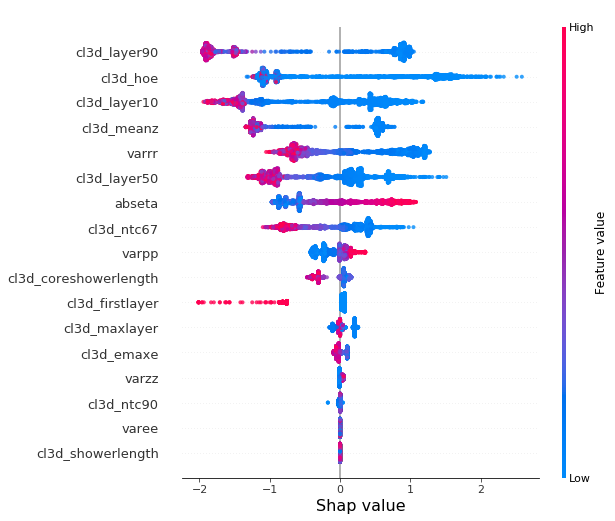

In [35]:
# shap values
import shap
# select a set of background examples to take an expectation over
#background = X_train.to_numpy()[np.random.choice(X_train.shape[0], 1000, replace=False)]

# explain predictions of the model on four images
explainer = shap.Explainer(BDT)
a= data[features][(data['signal']==1).values].sample(2000)
b = data[features][(data['signal']==0).values].sample(2000)
shap_df= pd.concat([a,b])

#shap_values = explainer.shap_values(X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)])
shap_values = explainer.shap_values(shap_df.to_numpy())
col_names=[val for val in shap_df.columns if val != 'abseta']
col_names.append('abseta')

plt.figure(figsize=(10,5))
#shap.summary_plot(shap_values, X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)], 
#                  features,max_display=99, show=False, alpha = 0.7 )

shap.summary_plot(shap_values, shap_df.to_numpy() ,shap_df.columns,max_display=99, show=False, alpha = 0.8 )
plt.xlabel('Shap value', fontsize=16)

plt.savefig(res_dir+'/importance_violin.png', bbox_inches='tight')


In [36]:
bkg

'pions'

In [37]:
# plot the feature attributions
#shap.image_plot(shap_values, -x_test[1:5])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], features)

In [38]:
# shap values
import shap
# select a set of background examples to take an expectation over
#background = X_train.to_numpy()[np.random.choice(X_train.shape[0], 1000, replace=False)]

# explain predictions of the model on four images
explainer = shap.Explainer(BDT)
a= X_test[(y_test['signal']==1).values].sample(500)
b = X_test[(y_test['signal']==0).values].sample(500)
shap_df= pd.concat([a,b])

#shap_values = explainer.shap_values(X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)])
shap_values = explainer.shap_values(shap_df.to_numpy())


In [39]:
col_names=[val for val in shap_df.columns if val != 'abseta']
col_names.append('abseta')


In [40]:
shap_df.columns

Index(['cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'varee', 'varzz', 'varpp', 'varrr', 'cl3d_emaxe',
       'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'abseta'],
      dtype='object')

In [41]:
col_names

['cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'varee',
 'varzz',
 'varpp',
 'varrr',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'abseta']

In [42]:
bkg

'pions'

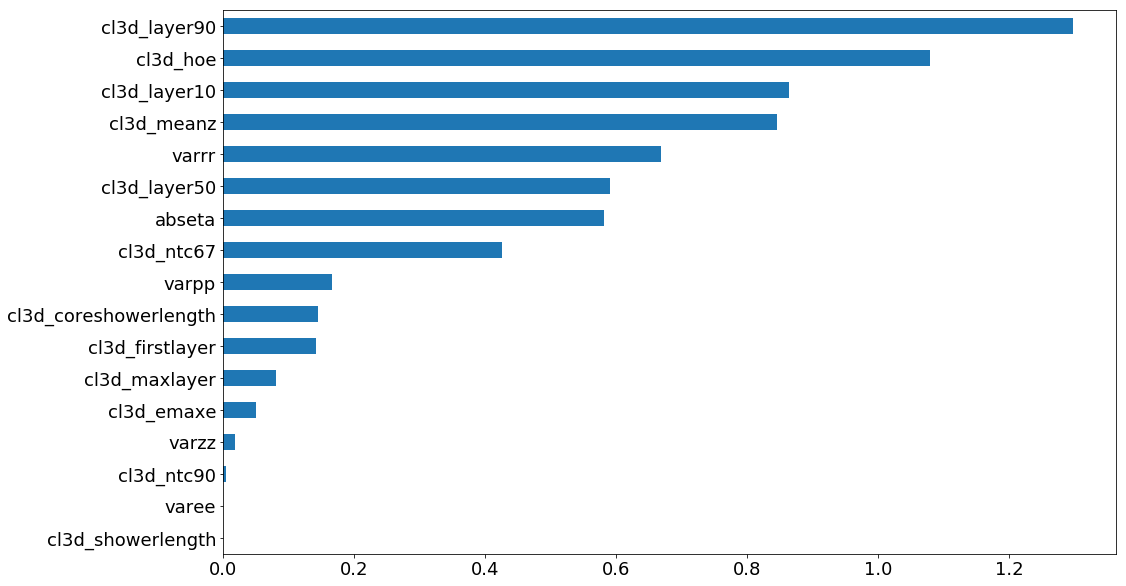

In [43]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
shap=pd.DataFrame(shap_values, columns=col_names)
shap_mean=[]
for column in shap.columns:
    shap_mean.append(np.abs(shap[column]).mean())
abs(shap).mean().sort_values().plot(kind='barh', figsize=(16,10))
plt.savefig(res_dir+'/importance_shap.png')

In [44]:
shap_values

array([[ 0.0000000e+00,  6.1893534e-02,  5.6249391e-02, ...,
         4.4304925e-01, -2.2628207e-03, -3.3272392e-01],
       [ 0.0000000e+00,  1.2617573e-01,  6.8134941e-02, ...,
         2.6086488e-01, -1.6289590e-02, -5.7342362e-01],
       [ 0.0000000e+00,  5.4365914e-02,  6.8134941e-02, ...,
         3.9446855e-01, -1.6289590e-02, -5.7039183e-01],
       ...,
       [ 0.0000000e+00,  6.3946985e-02,  3.6988687e-02, ...,
         1.0829004e-01,  2.8177875e-04, -4.2692414e-01],
       [ 0.0000000e+00,  6.0152240e-02, -8.1658393e-01, ...,
         7.5958646e-03, -3.4487669e-03, -8.7708235e-01],
       [ 0.0000000e+00, -3.0747005e-01,  2.3966581e-02, ...,
        -7.1440876e-01,  1.4677250e-03, -8.5944200e-01]], dtype=float32)


plt.figure(figsize=(8,4))
#shap.summary_plot(shap_values, X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)], 
#                  features,max_display=99, show=False, alpha = 0.7 )

shap.summary_plot(shap_values, shap_df.to_numpy() , col_names,max_display=99, show=False, alpha = 0.7 )
plt.xlabel('Shap value', fontsize=16)
plt.show()


AUC Score (Test): 99.692614%
AUC Score (Train): 99.872085%
score  = 1.1453113815318294%


<Figure size 1440x1080 with 0 Axes>

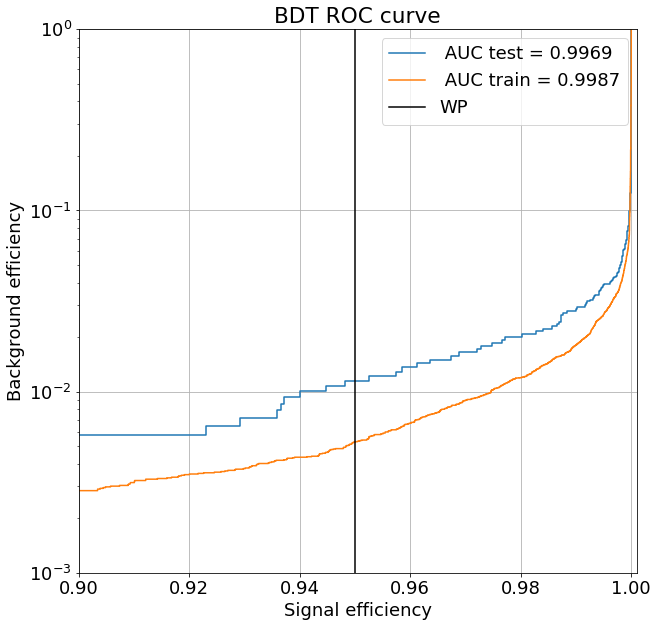

In [45]:
matplotlib.rcParams.update({'font.size': 18})
y_test['BDT']=predictions_BDT_test
#y_test['BDT_layer']=pred_PU_layer

plt.figure(figsize=(20,15))
score=[]
thr=0.95



#plot AUC
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
roc_cut_test=roc_test[roc_test['tpr']>thr];
print ("AUC Score (Test): {:4%}".format(roc_auc_test))
plt.plot(tpr,fpr, label =' AUC test = %0.4f' %(roc_auc_test))


fpr, tpr, threshold = roc_curve(y_train['signal'].astype('int32'),predictions_BDT_train, pos_label=1,sample_weight=y_train['weight'])
fpr.sort()
tpr.sort()
roc_auc_train = auc(fpr, tpr)
roc_auc_train = auc(fpr, tpr)
roc_train=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
roc_cut_train=roc_train[roc_train['tpr']>thr];
print ("AUC Score (Train): {:4%}".format(roc_auc_train))
plt.plot(tpr,fpr, label =' AUC train = %0.4f' %(roc_auc_train))
plt.xlim(0.9,1.001)
plt.yscale('log')
plt.ylim(1e-3,1.001)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve')
plt.axvline(x=thr, label='WP', c='k')
plt.grid()
plt.legend()
print('score  = {}%'.format(np.min(roc_cut_test['fpr'])*100))

In [46]:
# calc BDT cut
thr=0.99
BDT_cut=np.interp(thr,roc_test['tpr'], roc_test['threshold'])
with open(file_name, 'a') as f:
    f.write('BDT cut ={}  for tpr = {} and fpr {}\n'.format( np.interp(thr,roc_test['tpr'], roc_test['threshold']), np.interp(thr,roc_test['tpr'], roc_test['tpr']), np.interp(thr,roc_test['tpr'], roc_test['fpr'])))

print('BDT cut ={}  for tpr = {} and fpr {}'.format( np.interp(thr,roc_test['tpr'], roc_test['threshold']),
                                                    np.interp(thr,roc_test['tpr'], roc_test['tpr']),
                                                    np.interp(thr,roc_test['tpr'], roc_test['fpr'])))

BDT cut =0.693509326685649  for tpr = 0.99 and fpr 0.027916964924838316


In [47]:
#binning y_test


def calctp(group):
    pos=len(group[(group['BDT']>BDT_cut) & (group['signal']==1)])
    truepos= len(group[group['signal']==1])
    
    if truepos !=0 :return pos/truepos
    else : return np.nan
def calcfp(group):
    fp = len(group[(group['BDT']>BDT_cut) & (group['signal']==0)])
    trueneg = len(group[group['signal']==0])
    if trueneg !=0: return fp/trueneg
    else: return np.nan

In [48]:

#CALCULATE ERROR BARS
conf_level=0.99
from scipy import stats
#normal
#def error(total, score, conf_level):
#    alpha=(1-conf_level)/2
#    sigma=np.sqrt(score*(1-score)/total)
#    delta=np.abs(score-stats.norm.ppf(1-alpha,loc=score, scale=sigma))
#    return delta

#clopper pearson
def error(total, score, conf_level):
    alpha=(1-conf_level)
    n=total
    k=score*n
    lo = score-stats.beta.ppf(alpha/2, k, n-k+1)
    hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)-score
    return lo, hi


In [49]:
y_train=y_train_untouched

invalid value encountered in greater
invalid value encountered in greater
invalid value encountered in greater
invalid value encountered in greater


<Figure size 720x720 with 0 Axes>

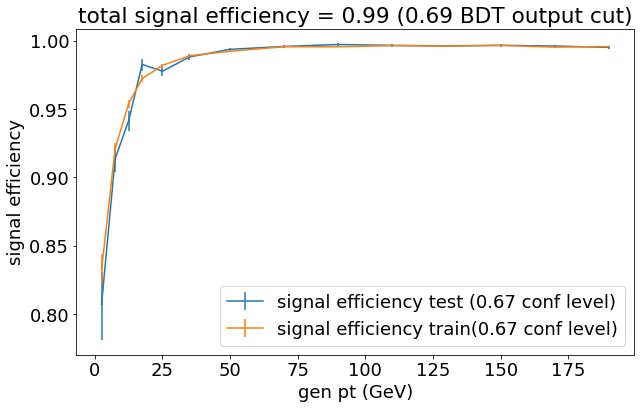

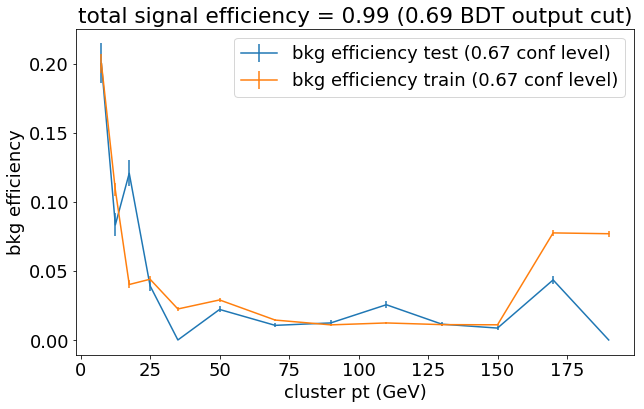

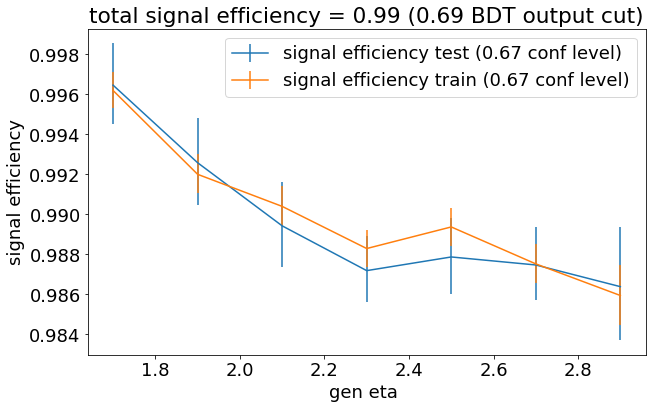

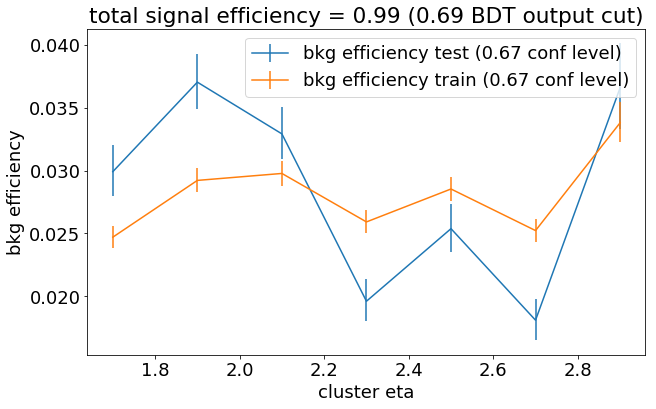

In [50]:
pt_bins=[0,5,10,15,20,30,40,60,80,100,120,140,160,180,200,220]
eta_bins=[1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0]
pt_points=[2.5,7.5,12.5,17.5,25,35,50,70,90,110,130,150,170,190,210]
eta_points=[1.7,1.9,2.1,2.3,2.5,2.7,2.9]
y_test['BDT']=predictions_BDT_test
y_train['BDT']=predictions_BDT_train_untouched

from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
"""fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
roc_cut_test=roc_test[roc_test['tpr']>thr];
"""
conf_level=0.67


y_test['genpt_binned']=pd.cut(y_test['genpart_pt'], pt_bins)
group=y_test.groupby('genpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_test.groupby('genpt_binned').size(), tpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='signal efficiency test ({} conf level)'.format(conf_level))
y_train['genpt_binned']=pd.cut(y_train['genpart_pt'], pt_bins)
group=y_train.groupby('genpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_train.groupby('genpt_binned').size(), tpr, conf_level)
plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='signal efficiency train({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}.png'.format(thr))


y_test['cl3dpt_binned']=pd.cut(y_test['cl3d_pt'], pt_bins)
group=y_test.groupby('cl3dpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_test.groupby('cl3dpt_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency test ({} conf level)'.format(conf_level))
y_train['cl3dpt_binned']=pd.cut(y_train['cl3d_pt'], pt_bins)
group=y_train.groupby('cl3dpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_train.groupby('cl3dpt_binned').size(), fpr, conf_level)
plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency train ({} conf level)'.format(conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvspt_WP{}.png'.format(thr))


y_test['geneta_binned']=pd.cut(np.abs(y_test['genpart_exeta']), eta_bins)
group=y_test.groupby('geneta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_test.groupby('geneta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='signal efficiency test ({} conf level)'.format(conf_level))
y_train['geneta_binned']=pd.cut(np.abs(y_train['genpart_exeta']), eta_bins)
group=y_train.groupby('geneta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_train.groupby('geneta_binned').size(), fpr, conf_level)
plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='signal efficiency train ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}.png'.format(thr))


y_test['cl3deta_binned']=pd.cut(np.abs(y_test['cl3d_eta']), eta_bins)
group=y_test.groupby('cl3deta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_test.groupby('cl3deta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency test ({} conf level)'.format(conf_level))

y_train['cl3deta_binned']=pd.cut(np.abs(y_train['cl3d_eta']), eta_bins)
group=y_train.groupby('cl3deta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y_train.groupby('cl3deta_binned').size(), fpr, conf_level)
plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency train ({} conf level)'.format(conf_level))

plt.ylabel('bkg efficiency')
plt.xlabel('cluster eta')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvseta_WP{}.png'.format(thr))



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
invalid value encountered in greater

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
invalid value encountered in greater

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

<Figure size 720x720 with 0 Axes>

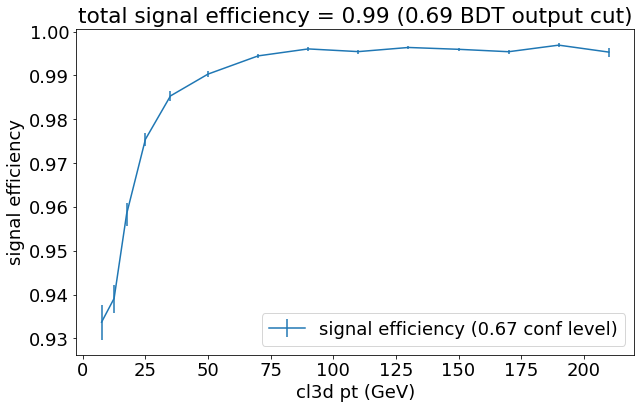

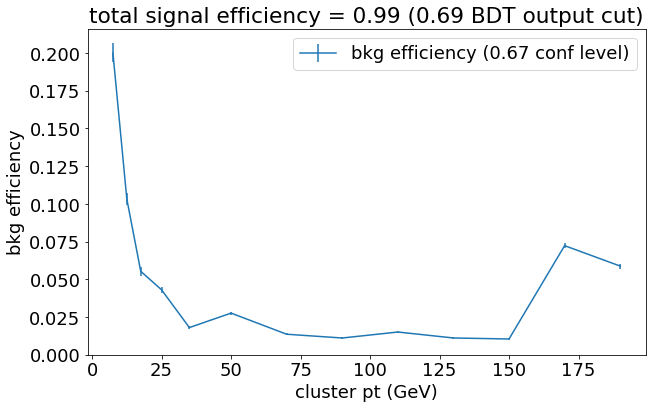

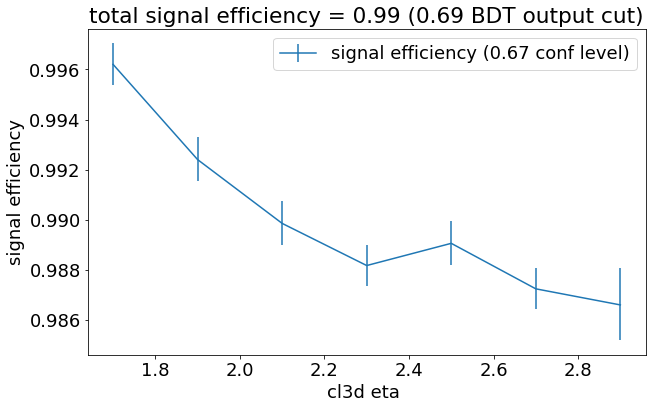

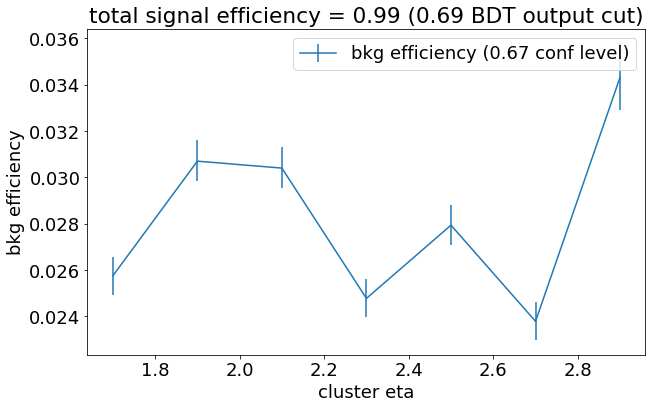

In [51]:
pt_bins=[0,5,10,15,20,30,40,60,80,100,120,140,160,180,200,220]
eta_bins=[1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0]
pt_points=[2.5,7.5,12.5,17.5,25,35,50,70,90,110,130,150,170,190,210]
eta_points=[1.7,1.9,2.1,2.3,2.5,2.7,2.9]
y=data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']]
sample = xgb.DMatrix(data=pd.DataFrame(X, columns=features),label=y['signal'],feature_names=features, weight=y['weight'])
y['BDT']=BDT.predict(sample)


from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y['signal'].astype('int32'),y['BDT'], pos_label=1,  sample_weight=y['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
roc_cut_test=roc_test[roc_test['tpr']>thr];

conf_level=0.67


y['cl3dpt_binned']=pd.cut(y['cl3d_pt'], pt_bins)
group=y.groupby('cl3dpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('cl3dpt_binned').size(), tpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('cl3d pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}.png'.format(thr))


y['cl3dpt_binned']=pd.cut(y['cl3d_pt'], pt_bins)
group=y.groupby('cl3dpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('cl3dpt_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency ({} conf level)'.format(conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvspt_WP{}.png'.format(thr))


y['cl3deta_binned']=pd.cut(np.abs(y['cl3d_eta']), eta_bins)
group=y.groupby('cl3deta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('cl3deta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('cl3d eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}.png'.format(thr))


y['cl3deta_binned']=pd.cut(np.abs(y['cl3d_eta']), eta_bins)
group=y.groupby('cl3deta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('cl3deta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency ({} conf level)'.format(conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster eta')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvseta_WP{}.png'.format(thr))



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
invalid value encountered in greater

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

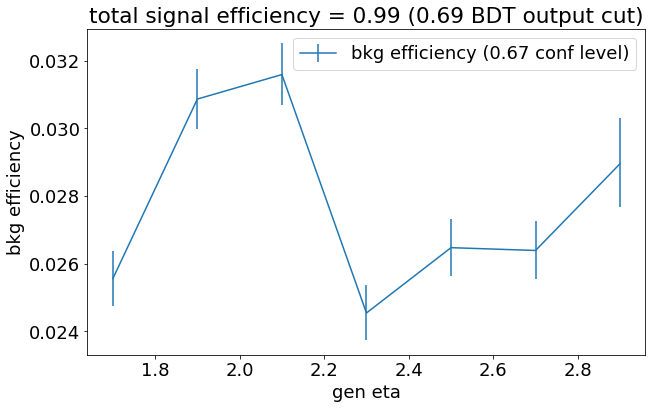

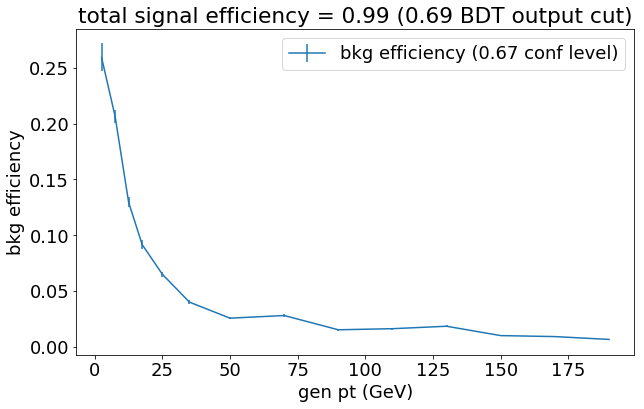

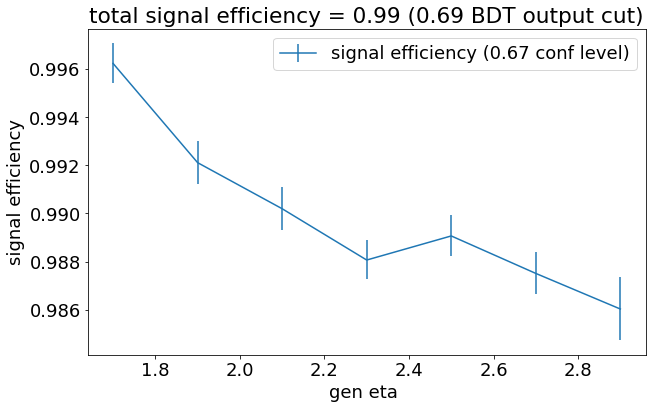

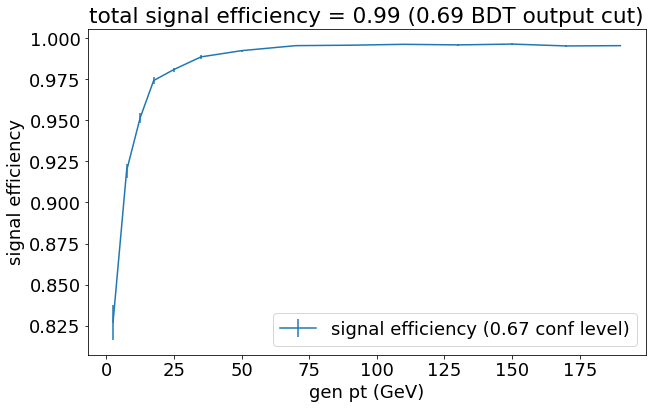

In [52]:
if bkg =='pions':
    
    y['geneta_binned']=pd.cut(np.abs(y['genpart_exeta']), eta_bins)
    group=y.groupby('geneta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=error(y.groupby('geneta_binned').size(), fpr, conf_level)
    plt.figure(figsize=(10,6))
    plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency ({} conf level)'.format(conf_level))
    plt.ylabel('bkg efficiency')
    plt.xlabel('gen eta')
    plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
    plt.legend(loc='best')
    plt.savefig(res_dir+'/bkgeffvseta_WP{}.png'.format(thr))

    y['genpt_binned']=pd.cut(y['genpart_pt'], pt_bins)
    group=y.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=error(y.groupby('genpt_binned').size(), fpr, conf_level)
    plt.figure(figsize=(10,6))
    plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency ({} conf level)'.format(conf_level))
    plt.ylabel('bkg efficiency')
    plt.xlabel('gen pt (GeV)')
    plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
    plt.legend(loc='best')
    plt.savefig(res_dir+'/bkgeffvspt_WP{}.png'.format(thr))
    
    y['geneta_binned']=pd.cut(np.abs(y['genpart_exeta']), eta_bins)
    group=y.groupby('geneta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=error(y.groupby('geneta_binned').size(), fpr, conf_level)
    plt.figure(figsize=(10,6))
    plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
    plt.ylabel('signal efficiency')
    plt.xlabel('gen eta ')
    plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
    plt.legend(loc='best')
    plt.savefig(res_dir+'/sigeffvseta_WP{}.png'.format(thr))

    y['genpt_binned']=pd.cut(y['genpart_pt'], pt_bins)
    group=y.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=error(y.groupby('genpt_binned').size(), tpr, conf_level)
    plt.figure(figsize=(10,6))
    plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
    plt.ylabel('signal efficiency')
    plt.xlabel('gen pt (GeV)')
    plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
    plt.legend(loc='best')
    plt.savefig(res_dir+'/sigeffvspt_WP{}.png'.format(thr))




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
invalid value encountered in greater


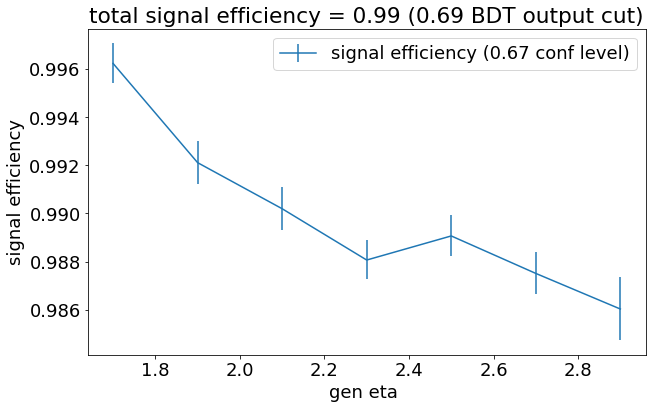

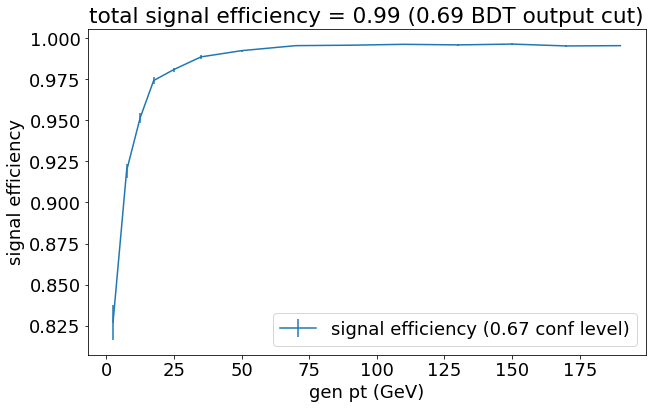

In [53]:
y['geneta_binned']=pd.cut(np.abs(y['genpart_exeta']), eta_bins)
group=y.groupby('geneta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('geneta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}.png'.format(thr))

y['genpt_binned']=pd.cut(y['genpart_pt'], pt_bins)
group=y.groupby('genpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=error(y.groupby('genpt_binned').size(), tpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}.png'.format(thr))

#res pion BDT
AUC Score (Test): 99.770155%
AUC Score (Train): 99.903230%
background rejection test = 0.9882920110192837, train = 0.994824909435915
#res PU BDT
AUC Score (Test): 99.901765%
AUC Score (Train): 99.914897%
background rejection test = 0.9994748699879739, train = 0.9995563555778215

In [54]:
data_dir

'/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/preprocessing/200PU_2806'

In [55]:
file= '/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/preprocessing/200PU/PU.h5'